In [1]:
import numpy as np
import pandas as pd
import math
import os
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
plt.rcParams.update({'font.size': 8})

In [2]:
def digitize_catg_feature(col_index, df):
    ladels = pd.factorize(df.iloc[:, col_index].unique(), na_sentinel=None)
    ladels_replacement = {}
    for i in range(len(ladels[0])): ladels_replacement[ladels[1][i]] = ladels[0][i]
    df.iloc[:, col_index] = df.iloc[:, col_index].replace(ladels_replacement)
    return df

# Wdbc
# data = pd.read_csv(f'datasets/DS01.data', header=None)
# data = data.replace('?', np.nan)
# data = digitize_catg_feature(1, data)
# data = data.dropna()
# data.insert(len(data.columns)-1, 'LABEL', data.pop(1))
# data.to_csv('datasets/DS01.csv', index=False)

# Lung canser
# data = pd.read_csv(f'datasets/DS02.data', header=None)
# data = data.replace('?', np.nan)
# data = data.dropna()
# data.insert(len(data.columns)-1, 'LABEL', data.pop(0))
# data.to_csv('datasets/DS02.csv', index=False)


In [3]:
class MOBGA_AOS:
    def __init__(self, LP = 5, max_nFE = 500, pop_size = 100, p_c = 0.9):
        self.max_nFE = max_nFE
        self.pop_size = pop_size
        self.operator_pool = ['single-point', 'two-point', 'uniform', 'shuffle', 'reduced-surrogate']
        self.LP = LP
        self.p_c = p_c

        # Q = pool_size
        self.Q = len(self.operator_pool)
        self.OSP = [1/self.Q for _ in range(self.Q)]

    def load_data(self, dataset_name):
        data = pd.read_csv(f'datasets/{dataset_name}').to_numpy()
        self.X = data[:, :-1]
        self.y = data[:, -1]
        self.d = self.X.shape[1]
        self.p_m = 1/self.d
        # self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, test_size=0.4, random_state=0)
    
    def init_pop(self):
        if(self.d > 250):
            pop = []
            for _ in range(self.pop_size):
                individual = np.zeros(self.d)
                ones_num = np.random.randint(20, 100)
                individual[:ones_num] = 1
                np.random.shuffle(individual)
                pop.append(individual)
            return pop
        else:
            return [np.random.choice([0, 1], size=self.d) for _ in range(self.pop_size)]
    
    def one_point_crossover(self, p1, p2):
        cross_point = np.random.randint(0, self.d)
        c1 = list(p1[:cross_point]) + list(p2[cross_point:])
        c2 = list(p2[:cross_point]) + list(p1[cross_point:])
        return [c1, c2]
    
    def two_point_crossover(self, p1, p2):
        cross_points = np.random.randint(0, self.d, 2)
        cross_points = np.sort(cross_points)
        c1 = list(p1[:cross_points[0]]) + list(p2[cross_points[0]:cross_points[1]]) + list(p1[cross_points[1]:])
        c2 = list(p2[:cross_points[0]]) + list(p1[cross_points[0]:cross_points[1]]) + list(p2[cross_points[1]:])
        return [c1, c2]

    def uniform_crossover(self, p1, p2):
        c1 = np.full(self.d, None).tolist()
        c2 = np.full(self.d, None).tolist()
        for i in range(self.d):
            rand_rate = np.random.uniform(0, 1)
            if(rand_rate >= 0.5):
                c1[i] = p1[i]
                c2[i] = p2[i]
            else:
                c1[i] = p2[i]
                c2[i] = p1[i]
        return [c1, c2]
    
    # def shuffle_crossover(self, p1, p2):
    #     c1, c2 = p1, p2
    #     index = np.random.choice(np.arange(0, self.d), self.d, replace = False)
    #     ran = np.random.randint(0, self.d)
    #     for i in range(ran):
    #         ind = index[i]
    #         c1[ind] = p2[ind]
    #         c2[ind] = p1[ind]
    #     return [c1, c2]
    
    def shuffle_crossover(self, p1, p2):
        len_ = len(p1)
        p1 = shuffle(p1)
        p2 = shuffle(p2)
        offsrping = self.one_point_crossover(p1, p2)
        return offsrping

    def reduced_surrogate_crossover(self, p1, p2):
        if(len(np.array(np.where(np.array(p1) != np.array(p2))).flatten()) > 0):
            cross_point = np.random.choice(np.array(np.where(np.array(p1) != np.array(p2))).flatten())
            c1 = list(p1[:cross_point]) + list(p2[cross_point:])
            c2 = list(p2[:cross_point]) + list(p1[cross_point:])
            return [c1, c2]
        else:
            return [p1, p2]
    
    def crossover(self, parents, operator_idx):
        p = np.random.uniform(0, 1)
        if p > self.p_c:
            return parents
        
        op_name = self.operator_pool[operator_idx]
        if(op_name == "single-point"):
            offspring = self.one_point_crossover(parents[0], parents[1])
        elif(op_name == "two-point"):
            offspring = self.two_point_crossover(parents[0], parents[1])
        elif(op_name == "uniform"):
            offspring = self.uniform_crossover(parents[0], parents[1])
        elif(op_name == "shuffle"):
            offspring = self.shuffle_crossover(parents[0], parents[1])
        elif(op_name == "reduced-surrogate"):
            offspring = self.reduced_surrogate_crossover(parents[0], parents[1])
        else:
            raise Exception("Unknown crossover operator!")
        
        for i, child in enumerate(offspring):
            if(not np.any(child)): 
                print(op_name)
                print("XOVER")
                print(f"C: {offspring[i]}")
                offspring[i] = parents[i]
                print(f"P: {parents[i]}")
        
        return offspring
    
    def mutation(self, individual):
        # Select a fraction of individual
        frac_idxs = np.random.choice(range(self.d), int(0.5 * self.d))
        indiv = individual.copy()
        for idx in frac_idxs:
            p = np.random.uniform(0, 1)
            if p < self.p_m:
                new_gene = np.random.randint(0, 2)
                # indiv[idx] = new_gene
                indiv[idx] = 0 if (indiv[idx] == 1) else 1
        if(not np.any(indiv)): 
            print("MUTE")
            print(f"C: {individual}")
            print(f"P: {indiv}")
            idx = np.random.randint(0, self.d)
            individual[idx] = 1
            return individual
        else:
            return indiv

    def score_individual_1(self, individual):
        model = KNeighborsClassifier(n_neighbors=3)
        indexes = np.array(np.where(np.array(individual) == 1)).flatten()
        X = (self.X[:, indexes]).reshape(len(self.X), len(indexes))
        ss = ShuffleSplit(n_splits=3, test_size=0.3, random_state=10)
        Nerr_Nall = []
        for train_index, test_index in ss.split(X):
            model.fit(X[train_index], self.y[train_index])
            y_pred = model.predict(X[test_index])
            y_test = self.y[test_index]
            # misclassified = np.where(y_test != y_pred)
            Nerr_Nall.append((np.sum(y_pred != y_test))/len(y_test))
        return np.round(np.mean(Nerr_Nall) * 100, 2)

    def score_individual_2(self, individual):
        return np.sum(individual)

    def fast_non_dominated_sort(self, values1, values2):
        S = [[] for i in range(0,len(values1))]
        front = [[]]
        n = [0 for i in range(0,len(values1))]
        rank = [0 for i in range(0, len(values1))]

        for p in range(0, len(values1)):
            S[p] = []
            n[p] = 0
            for q in range(0, len(values1)):
                if (values1[p] < values1[q] and values2[p] < values2[q]) \
                    or (values1[p] <= values1[q] and values2[p] < values2[q]) \
                    or (values1[p] < values1[q] and values2[p] <= values2[q]):
                    if q not in S[p]:
                        S[p].append(q)
                elif (values1[q] < values1[p] and values2[q] < values2[p]) \
                    or (values1[q] <= values1[p] and values2[q] < values2[p]) \
                    or (values1[q] < values1[p] and values2[q] <= values2[p]):
                    n[p] = n[p] + 1
            if n[p] == 0:
                rank[p] = 0
                if p not in front[0]:
                    front[0].append(p)

        i = 0
        while(front[i] != []):
            Q = []
            for p in front[i]:
                for q in S[p]:
                    n[q] = n[q] - 1
                    if(n[q] == 0):
                        rank[q] = i+1
                        if q not in Q:
                            Q.append(q)
            i = i+1
            front.append(Q)

        del front[len(front)-1]
        return front
    
    def index_locator(self, a, list):
        for i in range(0, len(list)):
            if list[i] == a:
                return i
        return -1

    def sort_by_values(self, list1, values):
        sorted_list = []
        while(len(sorted_list)!=len(list1)):
            if self.index_locator(min(values),values) in list1:
                sorted_list.append(self.index_locator(min(values),values))
            values[self.index_locator(min(values),values)] = math.inf
        return sorted_list

    def crowding_distance(self, values1, values2, front):
        distance = [0 for i in range(0,len(front))]
        sorted1 = self.sort_by_values(front, values1[:])
        sorted2 = self.sort_by_values(front, values2[:])
        distance[0] = 9999999999999999
        distance[len(front) - 1] = 9999999999999999
        for k in range(1,len(front)-1):
            distance[k] = distance[k] + (values1[sorted1[k+1]] - values2[sorted1[k-1]])/(max(values1)-min(values1))
        for k in range(1,len(front)-1):
            distance[k] = distance[k] + (values1[sorted2[k+1]] - values2[sorted2[k-1]])/(max(values2)-min(values2))
        return distance
        
    def update_OSP(self, RD, PN):
        S_q_1 = RD.sum(axis=0)
        S_q_2 = PN.sum(axis=0)

        S_q_3 = S_q_2
        S_q_3[S_q_3 == 0] = 0.0001

        S_q_4 = S_q_1/(S_q_2 + S_q_3)
        self.OSP = S_q_4/np.sum(S_q_4)
        if(np.isnan(self.OSP).all()): 
            print("OSP FUCKED")
            self.OSP = [1/self.Q for _ in range(self.Q)]

    def dominance_comparison(self, individuals):
        objective1_values = [self.score_individual_1(individual) for individual in individuals]
        objective2_values = [self.score_individual_2(individual) for individual in individuals]
        return self.fast_non_dominated_sort(objective1_values, objective2_values)

    def credit_assigment(self, parents, offspring, op_idx):
        paretos = self.dominance_comparison(offspring)

        if(len(paretos[0]) == 1):
            for i in range(2):
                individuals = [parents[paretos[0][0]], offspring[i]]
                comparisions = self.dominance_comparison(individuals)
                if(len(comparisions[0]) == 1 and comparisions[0][0] == 1):
                    self.n_penalty[op_idx] += 1
                else:
                    self.n_reward[op_idx] += 1
        else:
            for i in range(2):
                comparision_individuals = [parents[paretos[0][0]], offspring[i]]
                comparisions1 = self.dominance_comparison(comparision_individuals)
                comparision_individuals = [parents[paretos[0][1]], offspring[i]]
                comparisions2 = self.dominance_comparison(comparision_individuals)
                if((len(comparisions1[0]) != 1) and (len(comparisions2[0]) != 1)\
                   or (((len(comparisions1[0]) == 1) and comparisions1[0][0] != 1)\
                    and ((len(comparisions2[0]) == 1) and comparisions2[0][0] != 1))):
                    self.n_reward[op_idx] += 1
                else:
                    self.n_penalty[op_idx] += 1

    # def dominance_comparison(self, individuals):
    #     objective1_values = [self.score_individual_1(individual) for individual in individuals]
    #     objective2_values = [self.score_individual_2(individual) for individual in individuals]
    #     and_condition = True
    #     or_condition = False
    #     for first, second in zip(objective1_values, objective2_values):
    #         and_condition = and_condition and first <= second
    #         or_condition = or_condition or first < second
    #     return (and_condition and or_condition)

    # def dominance_comparison(self, individuals):
    #     objective1_values = [self.score_individual_1(individual) for individual in individuals]
    #     objective2_values = [self.score_individual_2(individual) for individual in individuals]
    #     return ((objective1_values[0] < objective1_values[1]) and (objective2_values[0] < objective2_values[1]))

    # def credit_assigment(self, parents, offspring, op_idx):
    #     p1_vs_p2 = self.dominance_comparison(parents)
    #     p2_vs_p1 = self.dominance_comparison([parents[1], parents[0]])

    #     # if(p1_vs_p2 == p2_vs_p1 and p1_vs_p2 == True):
    #     #     objective1_values = [self.score_individual_1(individual) for individual in parents]
    #     #     objective2_values = [self.score_individual_2(individual) for individual in parents]
    #     #     print(objective1_values)
    #     #     print(objective2_values)
    #     #     print(p2_vs_p1)
    #     #     print(p1_vs_p2)

    #     if(p1_vs_p2 or p2_vs_p1):
    #         if(p1_vs_p2): 
    #             non_dominated_parent = parents[0]
    #         else: 
    #             non_dominated_parent = parents[1]
    #         for i in range(2):
    #             individuals = [offspring[i], non_dominated_parent]
    #             ri_vs_p1 = self.dominance_comparison(individuals)
    #             if(ri_vs_p1):
    #                 self.n_penalty[op_idx] += 1
    #             else:
    #                 self.n_reward[op_idx] += 1
    #     else:
    #         for i in range(2):
    #             individuals = [offspring[i], parents[0]]
    #             ri_vs_p1 = self.dominance_comparison(individuals)
    #             individuals = [offspring[i], parents[1]]
    #             ri_vs_p2 = self.dominance_comparison(individuals)
    #             if((not ri_vs_p1) and (not ri_vs_p2)):
    #                 self.n_reward[op_idx] += 1
    #             else:
    #                 self.n_penalty[op_idx] += 1

    def plot_pareto_front(self):
        plt.figure(figsize=(6,5))
        PF = self.fast_non_dominated_sort(self.objective1_values, self.objective2_values)
        plt.xlabel('Solution size', fontsize=9)
        plt.ylabel('Classification error', fontsize=9)
        for idx in PF[0]:
            plt.scatter(self.objective2_values[idx], self.objective1_values[idx]/100, c='red', marker="*", s=25)
        plt.show()

    def fit(self):
        self.population = self.init_pop()
        RD = np.zeros((self.Q, self.LP))
        PN = np.zeros((self.Q, self.LP))
        self.n_reward = np.zeros(self.Q, dtype=int)
        self.n_penalty = np.zeros(self.Q, dtype=int)
        
        self.generation_count = 0
        self.nFE = 0
        k = 0
        while self.nFE < self.max_nFE:
            # self.generation_seed = int.from_bytes(os.urandom(5), 'big')
            # self.generation_seed = np.random.randint(0, 4294967295, dtype=np.int64)
            self.objective1_values = [self.score_individual_1(individual) for individual in self.population]
            self.objective2_values = [self.score_individual_2(individual) for individual in self.population]
            PF = self.fast_non_dominated_sort(self.objective1_values, self.objective2_values)
            if(self.generation_count %10 == 0 ):
                print('Best Individuals in Front-1 for Generation:', self.generation_count)
                for idx in PF[0]:
                    print(self.population[idx], end='')
                    print(f", O1: {self.score_individual_1(self.population[idx])} ", end='')
                    print(f"| O2: {self.score_individual_2(self.population[idx])}")
                print("\n")
            new_population = np.array(self.population[:])

            for i in range(int(self.pop_size/2)):
                # Selecting operator using roulette wheel selection
                operator_idx = np.random.choice(range(0, self.Q), p=self.OSP)
                # Randomly select two individuals as parents
                parents_idx = np.random.choice(range(0, self.pop_size), 2)
                parents = [self.population[idx] for idx in parents_idx]
                # Crossover
                offspirng = self.crossover(parents, operator_idx)
                # Mutation
                mutated_offspring = [self.mutation(individual) for individual in offspirng]
                self.credit_assigment(parents, offspirng, operator_idx)
                
                new_population = np.concatenate((new_population, mutated_offspring))
                self.nFE += 2
        
            RD[k, :] = self.n_reward
            PN[k, :] = self.n_penalty
            self.n_reward = np.zeros(self.Q, dtype=int)
            self.n_penalty = np.zeros(self.Q, dtype=int)
            k += 1
            if(k == self.LP):
                self.update_OSP(RD, PN)
                k = 0 

            objective1_values = [self.score_individual_1(individual) for individual in new_population]
            objective2_values = [self.score_individual_2(individual) for individual in new_population]
            non_dominated_sorted_solutions = self.fast_non_dominated_sort(objective1_values[:], objective2_values[:])
            crowding_distance_values=[]
            for i in range(len(non_dominated_sorted_solutions)):
                crowding_distance_values.append(self.crowding_distance(objective1_values[:], objective2_values[:], \
                                                                        non_dominated_sorted_solutions[i][:]))
            selected_solutions = []
            for i in range(len(non_dominated_sorted_solutions)):
                front_i_solutions = [self.index_locator(non_dominated_sorted_solutions[i][j], non_dominated_sorted_solutions[i]) \
                                                        for j in range(0, len(non_dominated_sorted_solutions[i]))]
                sorted_front_idxs = self.sort_by_values(front_i_solutions[:], crowding_distance_values[i][:])
                front = [non_dominated_sorted_solutions[i][sorted_front_idxs[j]] for j in range(len(non_dominated_sorted_solutions[i]))]
                front.reverse()
                for x in front:
                    selected_solutions.append(x)
                    if(len(selected_solutions) == self.pop_size):
                        break
                if (len(selected_solutions) == self.pop_size):
                    break
            self.population = np.array([new_population[i] for i in selected_solutions])
            
            self.generation_count += 1


In [4]:
ga_ds2 = MOBGA_AOS(max_nFE = 4500)
ga_ds2.load_data('DS02.csv')
ga_ds2.fit()

Best Individuals in Front-1 for Generation: 0
[1 1 1 0 1 1 1 0 0 1 1 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 1 1 1 0 1
 1 0 0 0 1 0 0 0 0 0 0 1 0 0 1 1 0 0 1], O1: 44.44 | O2: 21
[0 1 1 1 0 1 1 0 0 1 0 0 0 0 0 1 0 0 0 1 1 0 1 0 1 1 0 0 1 0 0 0 0 0 1 0 0
 0 1 0 0 0 0 1 1 1 1 0 1 0 1 0 0 0 0 1], O1: 33.33 | O2: 22
[1 1 1 0 0 1 0 1 0 1 1 0 0 0 1 0 1 0 1 1 1 0 1 1 1 0 1 0 0 0 0 0 0 0 1 0 1
 0 0 1 0 1 0 0 0 1 0 0 0 1 0 0 1 0 1 1], O1: 25.93 | O2: 25
[1 0 1 1 0 0 0 0 0 0 1 1 0 0 0 0 0 1 0 0 0 1 1 0 0 1 0 0 0 1 0 0 0 0 0 0 0
 1 1 1 0 1 0 1 0 0 0 0 1 1 0 0 1 0 0 1], O1: 70.37 | O2: 19


Best Individuals in Front-1 for Generation: 10
[0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0
 0 0 0 1 1 1 0 0 0 1 1 0 0 0 1 0 0 0 1], O1: 37.04 | O2: 12
[0 1 0 0 0 0 1 0 0 1 1 0 0 1 0 1 0 1 1 1 1 0 0 0 1 1 1 1 0 1 0 0 0 0 1 0 0
 0 0 1 0 0 1 0 1 1 0 0 1 0 0 1 1 0 0 0], O1: 11.11 | O2: 23
[0 1 0 0 0 1 0 0 0 1 0 1 0 1 0 1 0 0 0 1 0 0 0 0 1 0 0 1 1 0 0 0 1 0 0 0 0
 0 0 1 0 0 0 0 0 0 0

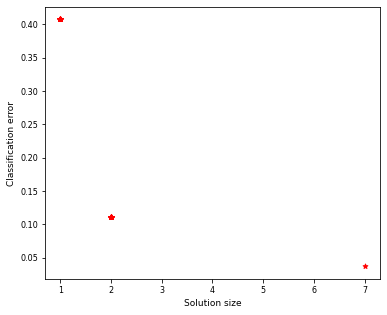

In [5]:
ga_ds2.plot_pareto_front()

In [6]:
ga_ds3 = MOBGA_AOS(max_nFE = 3000)
ga_ds3.load_data('DS03.csv')

In [7]:
ga_ds3.fit()

Best Individuals in Front-1 for Generation: 0
[0 0 1 0 0 1 0 1 1 1 1 0 0 1 1 1 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 1 1
 0 0 0 1 0 1 1 0 1 0 1 1 0 0 0 0 1 1 1 1 1 0 0], O1: 13.76 | O2: 25
[0 1 0 0 1 0 0 0 0 0 0 1 1 1 1 0 1 1 0 0 0 1 0 1 0 1 1 0 0 0 0 0 0 1 0 0 0
 1 1 0 0 0 1 1 1 1 0 0 1 0 1 0 0 0 1 0 0 0 1 1], O1: 24.34 | O2: 24
[0 0 0 1 1 1 0 1 1 0 0 0 1 0 0 0 1 1 0 1 1 0 0 0 1 0 0 0 1 1 1 0 1 0 0 0 1
 0 0 0 0 0 0 0 0 1 0 0 1 0 1 0 1 0 0 0 0 0 0 0], O1: 25.4 | O2: 20


Best Individuals in Front-1 for Generation: 10
[0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1 0 1
 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1], O1: 14.81 | O2: 11
[0 0 1 1 1 1 0 0 1 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 1 0 1 0 1 1
 0 0 0 0 0 0 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 0 0], O1: 12.17 | O2: 20
[0 0 1 1 1 1 0 0 1 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0 0 1 1 0 0 0 0 1 1
 0 0 0 1 0 1 0 0 0 0 1 1 0 1 1 0 1 1 0 0 0 0 0], O1: 10.58 | O2: 22
[1 1 0 0 0 0 0 1 1 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0

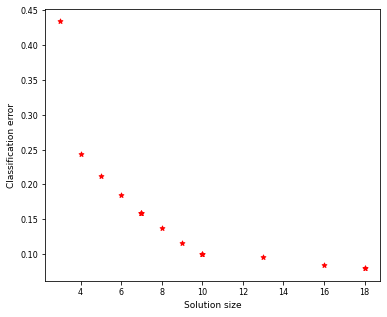

In [8]:
ga_ds3.plot_pareto_front()

In [9]:
ga_ds4 = MOBGA_AOS(max_nFE = 4000)
ga_ds4.load_data('DS04.csv')
ga_ds4.fit()

Best Individuals in Front-1 for Generation: 0
[1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 0 0 1 0 1 1 0 1 1 0 0 1 1 0 1 1 0 0 0 0 1 1
 1 1 0 0 1 1 1 0 1 0 1 1 1 0 0 1 0 1 0 0 1 0 1 0 1 0 1], O1: 3.22 | O2: 33
[0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 1 0 1 0 1 1 0 0 0 0
 0 0 0 0 0 1 1 1 1 0 1 0 0 0 1 1 1 0 1 0 1 1 1 0 0 0 0], O1: 6.44 | O2: 22
[0 0 1 0 0 1 0 0 0 0 0 0 0 0 1 1 0 0 1 0 1 1 0 1 1 0 1 0 1 0 0 0 0 0 1 1 0
 0 1 0 1 0 0 1 0 1 0 0 0 0 1 1 0 1 1 1 0 0 0 1 0 1 1 0], O1: 4.0 | O2: 25
[0 1 0 0 0 1 0 0 1 0 1 0 0 1 0 0 0 1 0 1 1 1 1 0 1 0 1 0 0 1 0 0 1 0 0 1 1
 1 1 1 1 1 1 1 1 0 1 1 0 0 1 0 1 0 0 1 0 0 0 1 0 1 1 0], O1: 3.56 | O2: 32
[0 0 1 1 1 1 0 1 1 1 1 1 0 0 0 0 0 0 0 1 0 1 1 0 0 0 1 0 0 0 0 0 1 1 1 0 0
 0 1 0 0 1 1 1 1 1 0 1 0 0 1 1 1 0 0 0 1 1 0 0 0 0 1 1], O1: 3.89 | O2: 30
[0 0 0 1 1 1 0 1 1 1 0 1 0 1 0 0 1 1 1 1 1 0 1 0 1 0 1 0 0 1 1 1 0 0 1 0 1
 0 1 1 0 1 1 1 0 1 1 1 1 0 0 1 0 1 0 0 0 0 1 1 1 1 1 0], O1: 2.78 | O2: 37


Best Individuals in Front-1 for Generation: 10
[0 0 0

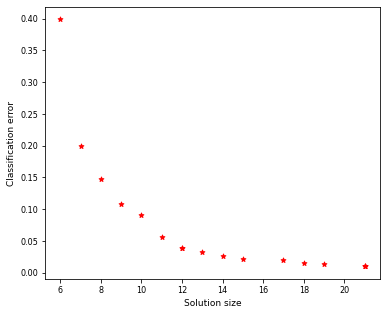

In [10]:
ga_ds4.plot_pareto_front()

In [11]:
mobga_ds5 = MOBGA_AOS(max_nFE = 4500)
mobga_ds5.load_data('DS05.csv')
mobga_ds5.fit()


Best Individuals in Front-1 for Generation: 0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0

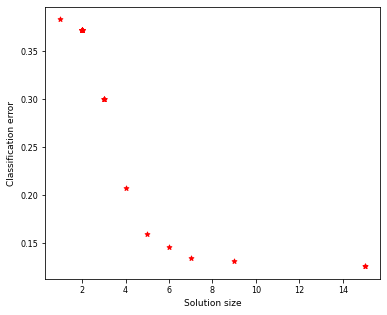

In [12]:
mobga_ds5.plot_pareto_front()

In [13]:
ga_ds7 = MOBGA_AOS(max_nFE = 5000)
ga_ds7.load_data('DS07.csv')
ga_ds7.fit()

Best Individuals in Front-1 for Generation: 0
[0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
 0. 1. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0.
 0. 1. 1. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0.
 0. 0

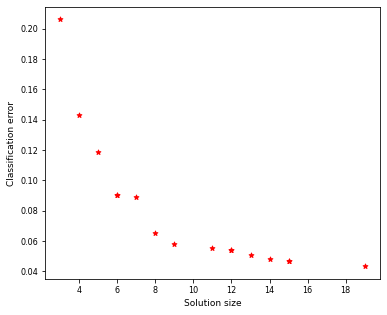

In [14]:
ga_ds7.plot_pareto_front()

In [15]:
ga_ds8 = MOBGA_AOS(max_nFE = 5000)
ga_ds8.load_data('DS08.csv')
ga_ds8.fit()

Best Individuals in Front-1 for Generation: 0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 0

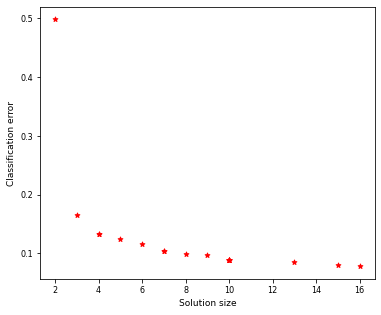

In [16]:
ga_ds8.plot_pareto_front()

In [17]:
ga_ds9 = MOBGA_AOS(max_nFE = 5000)
ga_ds9.load_data('DS09.csv')
ga_ds9.fit()

Best Individuals in Front-1 for Generation: 0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 0

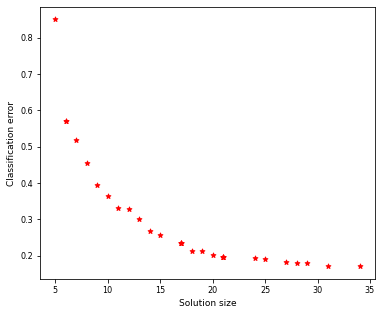

In [18]:
ga_ds9.plot_pareto_front()

In [19]:
mobga_ds10 = MOBGA_AOS(max_nFE = 4500)
mobga_ds10.load_data('DS10.csv')
mobga_ds10.fit()


Best Individuals in Front-1 for Generation: 0
[1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0.
 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1.
 0. 0

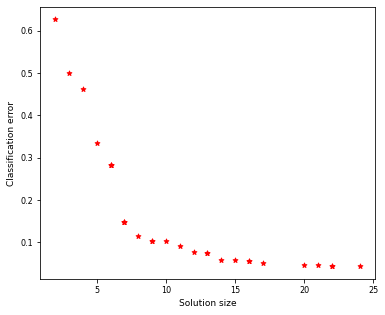

In [20]:
mobga_ds10.plot_pareto_front()